In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


In [122]:
def read_data(results_file, gene_name_file, annot_file=None):
    df = pd.read_csv(results_file, sep='\t')
    df['-log10_p'] = -np.log10(df['p_value'])

    # get gene names
    df_gene_name = pd.read_csv(gene_name_file, sep='\t')
    df = pd.merge(df, df_gene_name, how='left', on='uniprot_id')

    # get protein rank
    min_p = df.groupby('uniprot_id')['p_value'].min().reset_index()
    min_p['protein_rank'] = min_p['p_value'].rank(method='dense', ascending=True).astype(int)
    df = df.merge(min_p[['uniprot_id', 'protein_rank']], on='uniprot_id', how='left')

    if annot_file is not None:
        # merge with annotations
        df_ba = pd.read_csv(annot_file, sep='\t')
        df_ba_extra_cols = list([x for x in df_ba.columns if not x in ['uniprot_id', 'aa_pos']])
        df = pd.merge(df, df_ba, how='left', indicator=True)
        df['annotated'] = df['_merge'] == 'both'

    df['dist_annotated'] = df['annotated'].map({True: "0", False: ">0"})
    return df

In [118]:
def plot_a(df, colors, include_annot, ax):
    import numpy as np
    import seaborn as sns

    if max(df.protein_rank) <= 20:
        s = 15
    else:
        s = 5

    if include_annot:
        for d in sorted(df.dist_annotated.unique()):
            sns.scatterplot(data=df[df.dist_annotated==d], y='-log10_p', x='protein_rank', 
                        edgecolor=None, s=s, color=colors[d], label=d, ax=ax)
        for d in sorted(df.dist_annotated.unique(), reverse=True):
            sns.scatterplot(data=df[df.dist_annotated==d], y='-log10_p', x='protein_rank', 
                        edgecolor=None, s=s, color=colors[d], ax=ax)
        ax.legend(
            title='Distance from Binding/Active Site'
        )
    else:
        sns.scatterplot(data=df, y='-log10_p', x='protein_rank', edgecolor=None, s=s, color='#6C8EBF', ax=ax)

    xmax = ax.get_xlim()[1]
    if min(df.fdr) < 0.05:
        fdr_05_pval = np.mean([
            -np.log10(df.loc[df['fdr'] > 0.05, 'p_value'].min()), 
            -np.log10(df.loc[df['fdr'] < 0.05, 'p_value'].max()), 
        ])
        ax.axhline(y=fdr_05_pval, color='grey', linestyle='--', linewidth=1)
        ax.text(xmax, fdr_05_pval, 'FDR = 0.05', color='grey', va='bottom', ha='right')
    if min(df.fdr) < 0.001:
        fdr_001_pval = np.mean([
            -np.log10(df.loc[df['fdr'] > 0.001, 'p_value'].min()), 
            -np.log10(df.loc[df['fdr'] < 0.001, 'p_value'].max()), 
        ])
        ax.axhline(y=fdr_001_pval, color='black', linestyle='--', linewidth=1)
        ax.text(xmax, fdr_001_pval, 'FDR = 0.001', color='black', va='bottom', ha='right')

    ax.set_xlabel('Protein')
    ax.set_ylabel('-log10(p-value)')

    if max(df.protein_rank) <= 20:
        rank_to_gene = df.drop_duplicates('protein_rank').sort_values('protein_rank')[['protein_rank', 'gene_name']]
        ax.set_xticks(rank_to_gene['protein_rank'])
        ax.set_xticklabels(rank_to_gene['gene_name'], rotation=45, fontsize=8, ha='right')
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

def plot_b(df, fdr_threshold, colors, ax):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Define the two groups
    group_low = df[df.fdr < fdr_threshold]
    group_high = df[df.fdr > fdr_threshold]

    # Categories in order (hardcoded as in your example)
    categories = ["0", ">0"]

    # Calculate normalized counts (proportions) for each group
    props_low = group_low['dist_annotated'].value_counts(normalize=True).reindex(categories, fill_value=0)
    props_high = group_high['dist_annotated'].value_counts(normalize=True).reindex(categories, fill_value=0)

    # Stack the two groups into a DataFrame
    data = pd.DataFrame({
        f'FDR < {fdr_threshold}': props_low,
        f'FDR > {fdr_threshold}': props_high
    }).T

    # Clear the axis first (in case reused)
    ax.clear()

    # Stacked horizontal bars
    left = [0, 0]
    for cat in categories:
        ax.barh(data.index, data[cat], left=left, color=colors[cat], label=cat)
        left = [i + j for i, j in zip(left, data[cat])]

    # Labels and limits
    ax.set_xlabel('Proportion')
    ax.set_xlim(0, 1)

def plot_c(df, ax, n_rows=10):
    # Filter and prune dataframe
    annotated_df = df[df.annotated]

    pruned_df = annotated_df.loc[annotated_df.groupby('uniprot_id')['p_value'].idxmin()]

    def coalesce_with_label(row):
        if pd.notna(row['Binding site (UniProt)']):
            return f"{row['Binding site (UniProt)']} binding site"
        elif pd.notna(row['Active site (UniProt)']):
            return row['Active site (UniProt)']
        else:
            return pd.NA

    pruned_df['Site'] = pruned_df.apply(coalesce_with_label, axis=1)

    cols_to_use = ['gene_name', 'p_value', 'fdr', 'Site']
    table_to_plot = pruned_df.sort_values('p_value').head(n_rows)[cols_to_use].reset_index(drop=True)

    # Format p_value and fdr columns
    table_to_plot['p_value'] = table_to_plot['p_value'].apply(lambda x: f"{x:.3g}")
    table_to_plot['fdr'] = table_to_plot['fdr'].apply(lambda x: f"{x:.3g}")
    table_to_plot['fdr'] = table_to_plot['fdr'].apply(lambda x: '<1e-5' if x == '0' else x)

    # Italicize gene names using mathtext
    table_to_plot['gene_name'] = table_to_plot['gene_name'].apply(lambda x: f"$\\it{{{x}}}$")

    # Rename columns for display
    table_to_plot.rename({
        'gene_name':'Gene',
        'p_value':'P value',
        'fdr': 'FDR',
    }, axis=1, inplace=True)

    # Clear axis and hide it
    ax.clear()
    ax.axis('off')

    # Create table plot
    tab = ax.table(cellText=table_to_plot.values,
                   colLabels=table_to_plot.columns,
                   cellLoc='center',
                   colLoc='center',
                   loc='center')

    tab.auto_set_font_size(False)
    tab.set_fontsize(9)

    # Adjust column widths roughly
    col_widths = [0.2, 0.15, 0.15, 0.5]
    for i, width in enumerate(col_widths):
        tab.auto_set_column_width(i)
        for key, cell in tab.get_celld().items():
            if key[1] == i:
                cell.set_width(width)

    # ax.text(0.5, 0.9, 'Top annotated results', transform=ax.transAxes, 
        # fontsize=11, fontweight='bold', ha='center', va='top')
    ax.title.set_text('Top annotated results')
    plt.tight_layout()

def full_fig(df, fdr_threshold, save_path):
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 2])
    colors = {
        '0': '#E66100',       # orange-red
        '>0': '#6C8EBF'      # blue-grey
    }

    # ax_a = fig.add_subplot(gs[:, 0])   # full height left half
    # ax_b = fig.add_subplot(gs[0, 1])   # top right
    # ax_c = fig.add_subplot(gs[1, 1])   # bottom right
    ax_a = fig.add_axes([0.08, 0.12, 0.5, 0.75])  # left plot - matches table bottom
    ax_b = fig.add_axes([0.70, 0.65, 0.3, 0.22])  # top right
    ax_c = fig.add_axes([0.70, 0.10, 0.25, 0.35])  # bottom right - same bottom as left plot

    plot_a(df, colors, include_annot=True, ax=ax_a)
    plot_b(df, fdr_threshold, colors, ax=ax_b)
    plot_c(df, ax=ax_c)

    ax_a.text(-0.1, 1.02, 'a', transform=ax_a.transAxes, fontsize=14, fontweight='bold', va='bottom')
    ax_b.text(-0.3, 1.05, 'b', transform=ax_b.transAxes, fontsize=14, fontweight='bold', va='bottom')
    ax_c.text(-0.3, 1.02, 'c', transform=ax_c.transAxes, fontsize=14, fontweight='bold', va='bottom')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


In [136]:
def plot_a_only(df):
    fig = plt.figure(figsize=(6, 6))
    colors = {
        '0': '#E66100',       # orange-red
        '>0': '#6C8EBF'      # blue-grey
    }

    plot_a(df, colors, include_annot=True, ax=plt.gca())

/var/folders/wn/zdhr032107vgcxgxv6910v7w0000gp/T/ipykernel_43630/1131399952.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


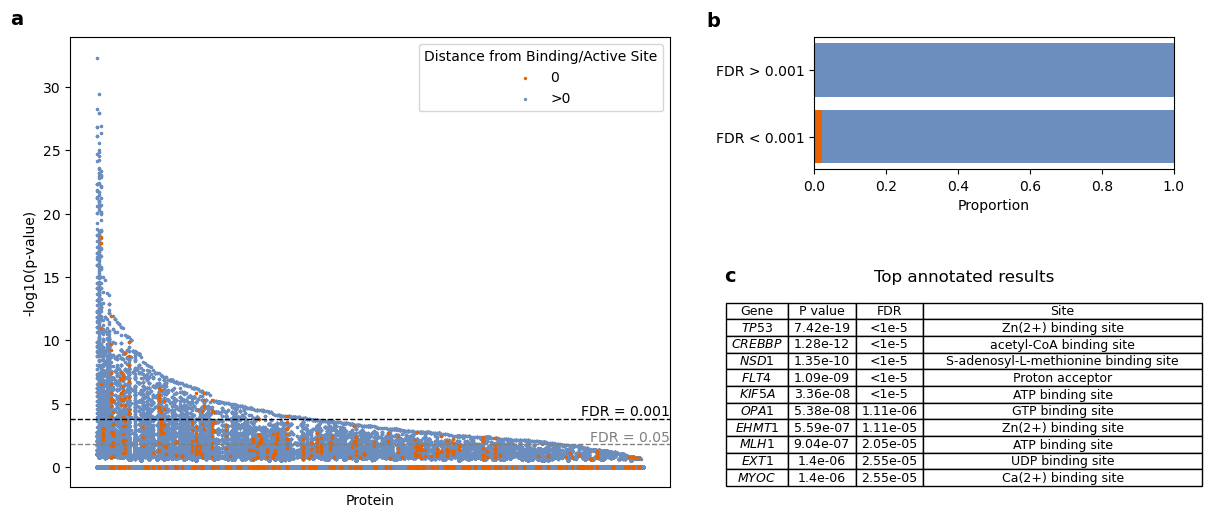

In [ ]:
# results_file = '../sir_schema10/results_ac_5/all_proteins.fdr.tsv'
# results_file = '../sir_bipex/results_ac_5/all_proteins.fdr.tsv'

results_file = '../sir_clinvar/results/all_proteins.fdr.tsv'
save_path = '../sir_clinvar/results/overall_results.pdf'
annot_file = '../sir-reference-data/annotations/g2p_binding_site_active_site.tsv'
gene_name_file = '../sir-reference-data/gene_to_uniprot_id.tsv'
fdr_threshold = 0.001

df = read_data(results_file, gene_name_file, annot_file)
full_fig(df, fdr_threshold, save_path)

/var/folders/wn/zdhr032107vgcxgxv6910v7w0000gp/T/ipykernel_43630/1131399952.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


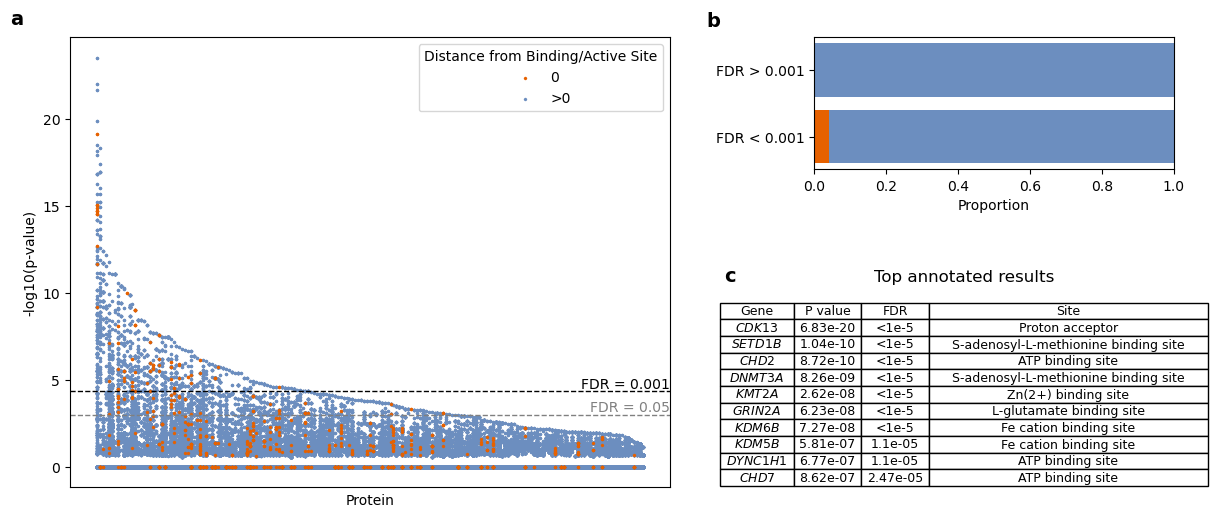

In [ ]:
results_file = '../sir_asd/results/all_proteins_72.fdr.tsv'
save_path = '../sir_asd/results/overall_results.pdf'
annot_file = '../sir-reference-data/annotations/g2p_binding_site_active_site.tsv'
gene_name_file = '../sir-reference-data/gene_to_uniprot_id.tsv'
fdr_threshold = 0.001

df = read_data(results_file, gene_name_file, annot_file)
full_fig(df, fdr_threshold, )

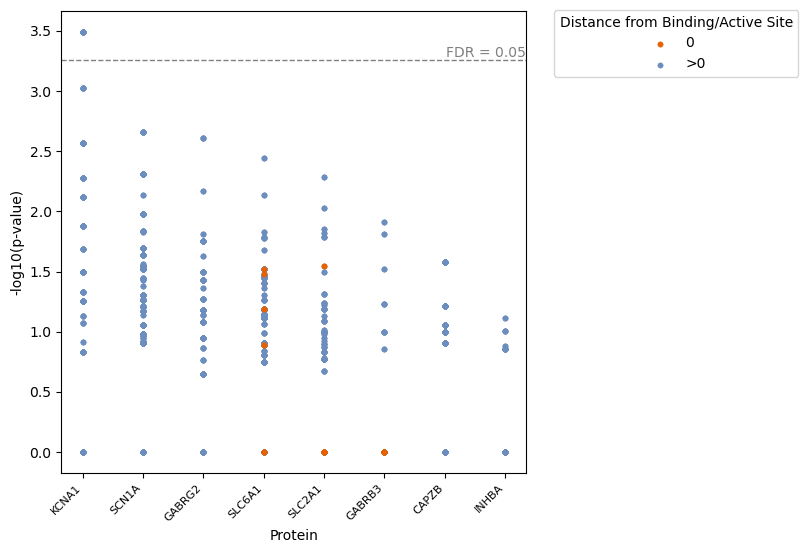

In [149]:
results_file = '../sir_epi25/results_from_emily/all_proteins.fdr.tsv'
save_path = '../sir_epi25/results_from_emily/overall_results.pdf'
annot_file = '../sir-reference-data/annotations/g2p_binding_site_active_site.tsv'
gene_name_file = '../sir-reference-data/gene_to_uniprot_id.tsv'
fdr_threshold = 0.1

df = read_data(results_file, gene_name_file, annot_file)
plot_a_only(df)
plt.legend(
    loc='center right',
    title='Distance from Binding/Active Site',
    bbox_to_anchor=(1.6, 0.93)
)
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

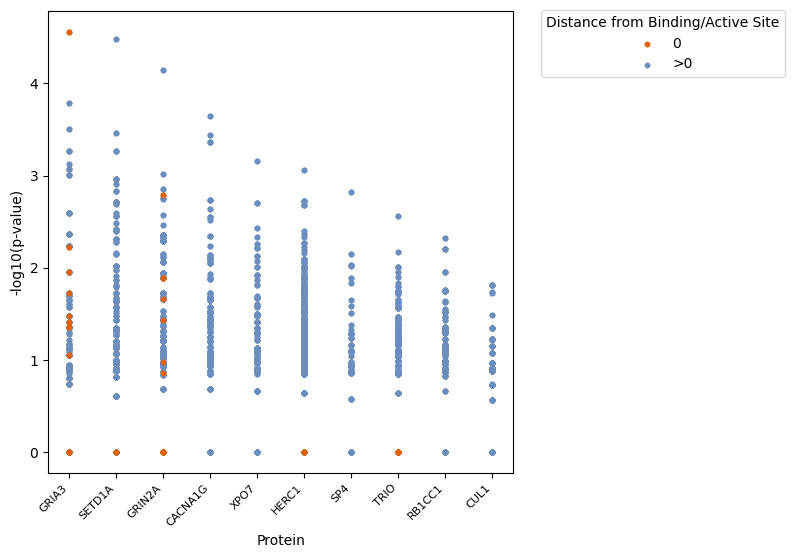

In [153]:
results_file = '../sir_schema10/results_ac_5/all_proteins.fdr.tsv'
save_path = '../sir_schema10/results_ac_5/overall_results.pdf'
annot_file = '../sir-reference-data/annotations/g2p_binding_site_active_site_plus_minus_1.tsv'
gene_name_file = '../sir-reference-data/gene_to_uniprot_id.tsv'
fdr_threshold = 0.1

df = read_data(results_file, gene_name_file, annot_file)
plot_a_only(df)
plt.legend(
    loc='center right',
    title='Distance from Binding/Active Site',
    bbox_to_anchor=(1.6, 0.93)
)
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()